In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, os
from pathlib import Path
import sympy as sp
from pysr import PySRRegressor  # requires Julia
import json
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)

from data_processor import load_features_and_split3  # your helper

SEED = 42
np.random.seed(SEED)
ARTIFACTS = Path("artifacts"); ARTIFACTS.mkdir(exist_ok=True, parents=True)

# Use the same split (load if already saved for consistency)
test_feat = ARTIFACTS / "features_test.parquet"
test_y    = ARTIFACTS / "y_test.parquet"
if test_feat.exists() and test_y.exists():
    X_test = pd.read_parquet(test_feat)
    y_test = pd.read_parquet(test_y)["y"].astype(int).values
    # Rebuild train/val similarly if you also saved them; otherwise recreate deterministically:
    X_train, X_val, X_test2, y_train, y_val, y_test2 = load_features_and_split3(
        "orbit_results_sobol_4.csv", test_size=0.20, val_size=0.10, random_state=SEED, stratify=True
    )
    # Overwrite test with the saved one to be safe:
    X_test = pd.read_parquet(test_feat); y_test = pd.read_parquet(test_y)["y"].astype(int).values
else:
    X_train, X_val, X_test, y_train, y_val, y_test = load_features_and_split3(
        "orbit_results_sobol_4.csv", test_size=0.20, val_size=0.10, random_state=SEED, stratify=True
    )

feat_names = list(X_train.columns)
print("Features:", feat_names)


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Features: ['r0', 'v0', 'cos_dtheta', 'sin_dtheta', 'mass', 'rTarget']


In [2]:
# Class weights: mirror BDT's scale_pos_weight
from pysr import PySRRegressor
import numpy as np

spw = float((y_train == 0).sum() / max((y_train == 1).sum(), 1))
weights = np.where(y_train.values == 1, spw, 1.0).astype(np.float32)

model_sr = PySRRegressor(
    niterations=600,
    populations=20,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["sin", "cos", "tanh", "exp"],
    # NOTE: 3-arg loss: prediction x, target y, weight w
    loss="loss(x, y, w) = w * ( y*log1p(exp(-x)) + (1 - y)*log1p(exp(x)) )",
    model_selection="best",
    maxsize=24,
    progress=True,
    verbosity=0, 
    random_state=SEED,
)

# (Optional but nice: send float32 to Julia)
Xtr32 = X_train.values.astype(np.float32)
ytr32 = y_train.values.astype(np.float32)

model_sr.fit(Xtr32, ytr32, weights=weights)


# Select best equation by validation AUC (same as before) but use sigmoid at eval:
import sympy as sp
xs = sp.symbols(" ".join([f"x{i}" for i in range(X_train.shape[1])]))

def make_callable(expr_str):
    expr = sp.sympify(expr_str)
    f = sp.lambdify(xs, expr, modules="numpy")
    return f

pareto = model_sr.equations_
Xv, yv = X_val.values, y_val.values
best_auc, best_idx, best_fn = -1.0, None, None

for i, row in pareto.reset_index(drop=True).iterrows():
    fn = make_callable(str(row["equation"]))
    try:
        logit = fn(*[Xv[:, j] for j in range(Xv.shape[1])])
        proba = 1.0 / (1.0 + np.exp(-np.asarray(logit, dtype=float)))  # sigmoid
        if not np.isfinite(proba).all():
            continue
        auc = roc_auc_score(yv, proba)
        if auc > best_auc:
            best_auc, best_idx, best_fn = auc, i, fn
    except Exception:
        continue

print("Best val AUC:", best_auc, "idx:", best_idx)
def sr_predict_proba(Xdf):
    Xn = Xdf.values
    logit = best_fn(*[Xn[:, j] for j in range(Xn.shape[1])])
    return 1.0 / (1.0 + np.exp(-np.asarray(logit, dtype=float)))


/home/coffee/miniconda3/envs/a356/lib/python3.9/site-packages/pysr/sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/home/coffee/miniconda3/envs/a356/lib/python3.9/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
/home/coffee/miniconda3/envs/a356/lib/python3.9/site-packages/pysr/sr.py:1873: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.330e+03
Progress: 25 / 12000 total iterations (0.208%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.041e-01  0.000e+00  y = 0.29677
2           6.932e-01  1.568e-02  y = sin(0.0065162)
3           6.631e-01  4.430e-02  y = x₄ - 0.5593
4           6.610e-01  3.169e-03  y = x₄ - cos(x₂)
5           6.514e-01  1.464e-02  y = (x₄ + -0.56065) / 0.46195
6           6.473e-01  6.328e-03  y = (x₄ - cos(x₂)) * 2.0856
8           5.228e-01  1.068e-01  y = tanh(x₁ + (x₁ / x₂)) * x₀
10          4.332e-01  9.393e-02  y = (tanh((x₁ / x₂) + x₁) * x₀) - x₂
12          4.189e-01  1.679e-02  y = ((x₀ * tanh((x₁ / x₂) + x₁)) - x₂) / 0.72546
14          4.176e-01  1.625e-03  y = (((x₀ * tanh((x₁ / x₂) + x₁)) - x₂) / 0.72546) + x₃
18          4.046e-01  7.912e-

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.931e-01  0.000e+00  y = -4.0421e-06
3           6.603e-01  2.429e-02  y = x₄ / x₁
4           6.111e-01  7.742e-02  y = cos(x₃ * 18.337)
5           6.105e-01  9.576e-04  y = cos(exp(x₃) * -18.688)
6           5.809e-01  4.974e-02  y = cos(x₃ * (x₁ * -3.5045))
7           5.071e-01  1.357e-01  y = cos(tanh(x₃ * x₁) * 3.8971)
8           3.976e-01  2.433e-01  y = (cos(x₁ * x₃) + -0.94421) * 25.83
9           3.918e-01  1.469e-02  y = (cos(tanh(x₁ * x₃)) + -0.95204) * 31.782
10          3.741e-01  4.628e-02  y = x₄ + ((-0.96584 + cos(x₁ * x₃)) / 0.038977)
11          3.651e-01  2.435e-02  y = exp(x₄) + ((cos(x₁ * x₃) + -1.014) / 0.038349)
12          3.550e-01  2.810e-02  y = (x₄ * 3.1051) + ((cos(x₁ * x₃) + -1.0066) / 0.035929)
13          3.489e-01  1.731e-02  y = (x₄ * 3.1063) + ((cos(tanh(x₁ * x₃)) + -1.0027) / 0.02...
          

Selected SR equation (raw PySR form):
((x1 * tanh(((x1 / -1.4926332) + (x0 / 3.0070467)) * (((x1 / x2) + x1) + (x3 * 0.037296787)))) + x4) * 3.7193508

Selected SR equation (named features):
                                  ⎛                                            ↪
3.7193508⋅mass + 3.7193508⋅v₀⋅tanh⎜(0.332552201467307⋅r₀ - 0.669956959285108⋅v ↪
                                  ⎝                                            ↪

↪    ⎛                                  v₀    ⎞⎞
↪ ₀)⋅⎜0.037296787⋅sin_dtheta + v₀ + ──────────⎟⎟
↪    ⎝                              cos_dtheta⎠⎠

LaTeX:
3.7193508 mass + 3.7193508 v_{0} \tanh{\left(\left(0.332552201467307 r_{0} - 0.669956959285108 v_{0}\right) \left(0.037296787 sin_{dtheta} + v_{0} + \frac{v_{0}}{cos_{dtheta}}\right) \right)}

Equation metadata: {'complexity': 24, 'loss': 0.29651704, 'score': 0.005892685903296238}
Saved sr_equation.txt, sr_equation_named.txt, sr_equation_named.tex
Symbolic  ROC AUC: 0.9447
Symbolic  PR  AUC: 0.6791

Classif

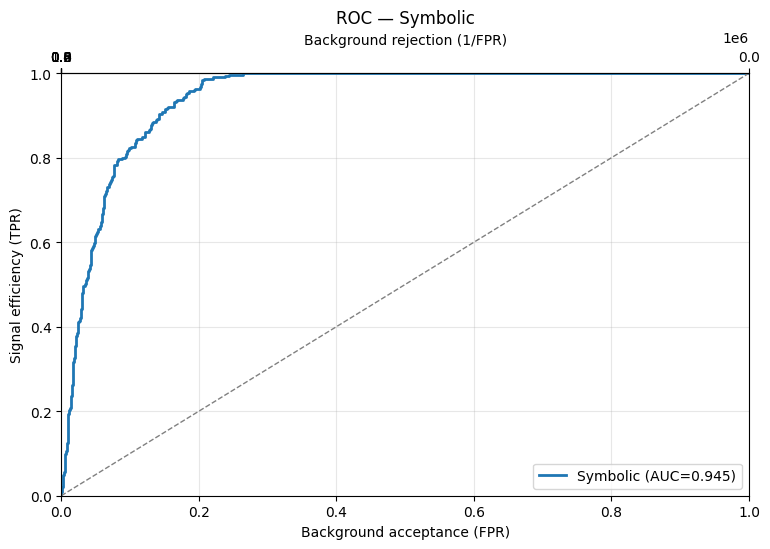

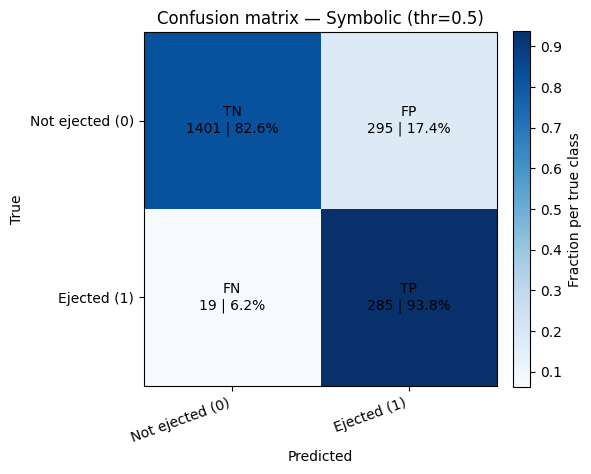

In [5]:
# === Report the selected symbolic equation ===
import sympy as sp

eq_df = getattr(model_sr, "equations_", pareto)   # use the PySR Pareto front
eq_str_raw = str(eq_df.iloc[best_idx]["equation"])

# Pretty-print with your actual feature names instead of x0, x1, ...
n_features = len(feat_names)
expr = sp.sympify(eq_str_raw)
subs = {sp.Symbol(f"x{i}"): sp.Symbol(feat_names[i]) for i in range(n_features)}
expr_named = expr.xreplace(subs)

print("Selected SR equation (raw PySR form):")
print(eq_str_raw)
print("\nSelected SR equation (named features):")
print(sp.pretty(expr_named))
print("\nLaTeX:")
print(sp.latex(expr_named))

# Optional: show a couple of metadata columns if present
meta_cols = [c for c in ["complexity", "loss", "score"] if c in eq_df.columns]
if meta_cols:
    print("\nEquation metadata:", eq_df.iloc[best_idx][meta_cols].to_dict())

# Optional: save for your artifacts
ARTIFACTS.mkdir(exist_ok=True, parents=True)
with open(ARTIFACTS / "sr_equation.txt", "w") as f:
    f.write(eq_str_raw + "\n")
with open(ARTIFACTS / "sr_equation_named.txt", "w") as f:
    f.write(sp.sstr(expr_named) + "\n")
with open(ARTIFACTS / "sr_equation_named.tex", "w") as f:
    f.write(sp.latex(expr_named) + "\n")
print("Saved sr_equation.txt, sr_equation_named.txt, sr_equation_named.tex")

proba_sr = sr_predict_proba(X_test)
pred_sr  = (proba_sr >= 0.5).astype(int)

print(f"Symbolic  ROC AUC: {roc_auc_score(y_test, proba_sr):.4f}")
print(f"Symbolic  PR  AUC: {average_precision_score(y_test, proba_sr):.4f}")
print("\nClassification report:\n", classification_report(y_test, pred_sr, digits=3))

# ROC with rejection axis
fpr, tpr, _ = roc_curve(y_test, proba_sr)
plt.figure(figsize=(7.8,5.6))
plt.plot(fpr, tpr, lw=2, label=f"Symbolic (AUC={roc_auc_score(y_test, proba_sr):.3f})")
plt.plot([0,1],[0,1],'--',lw=1,color='gray')
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Background acceptance (FPR)")
plt.ylabel("Signal efficiency (TPR)")
plt.title("ROC — Symbolic")
def fwd(f): f=np.clip(np.array(f),1e-6,1.0); return 1.0/f
def inv(r): r=np.clip(np.array(r),1.0,1e6);  return 1.0/r
plt.gca().secondary_xaxis('top', functions=(fwd, inv)).set_xlabel("Background rejection (1/FPR)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# Confusion matrix (pretty)
cm  = confusion_matrix(y_test, pred_sr)
cmn = cm / cm.sum(axis=1, keepdims=True)
labels = np.array([["TN","FP"],["FN","TP"]])
classes = ["Not ejected (0)", "Ejected (1)"]

fig, ax = plt.subplots(figsize=(6,5.5))
im = ax.imshow(cmn, cmap="Blues")
ax.set_title("Confusion matrix — Symbolic (thr=0.5)")
ax.set_xticks([0,1], labels=classes, rotation=20, ha="right")
ax.set_yticks([0,1], labels=classes)
for (i,j), v in np.ndenumerate(cmn):
    ax.text(j,i,f"{labels[i,j]}\n{cm[i,j]} | {v*100:.1f}%", ha="center", va="center", fontsize=10)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Fraction per true class")
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); plt.tight_layout(); plt.show()


In [6]:

ARTIFACTS.mkdir(exist_ok=True, parents=True)

expr_str = str(model_sr.equations_.iloc[best_idx]["equation"])  # from the selection loop above

meta = {
    "framework": "pysr",
    "equation": expr_str,                  # the chosen formula
    "selected_index": int(best_idx),       # index in equations_ (for reference)
    "feature_names": list(X_train.columns),
    "val_auc": float(best_auc),
    "threshold": 0.5,                      # update later if you threshold-tune
    "interpretation": "sigmoid"            # or "clip" if you used MSE-as-prob
}
with open(ARTIFACTS / "sr_pysr_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

# Optional: keep the whole Pareto front for your report
model_sr.equations_.to_csv(ARTIFACTS / "sr_pysr_equations.csv", index=False)
print("Saved sr_pysr_meta.json and sr_pysr_equations.csv")


Saved sr_pysr_meta.json and sr_pysr_equations.csv
